In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!python -V

Python 3.7.7


In [5]:
data = pd.read_csv("FB.csv",parse_dates=['Date'],index_col='Date')

data_last_14days = data.iloc[-15:-1]
data = data.iloc[:-15]

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [7]:
def make_dataset(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

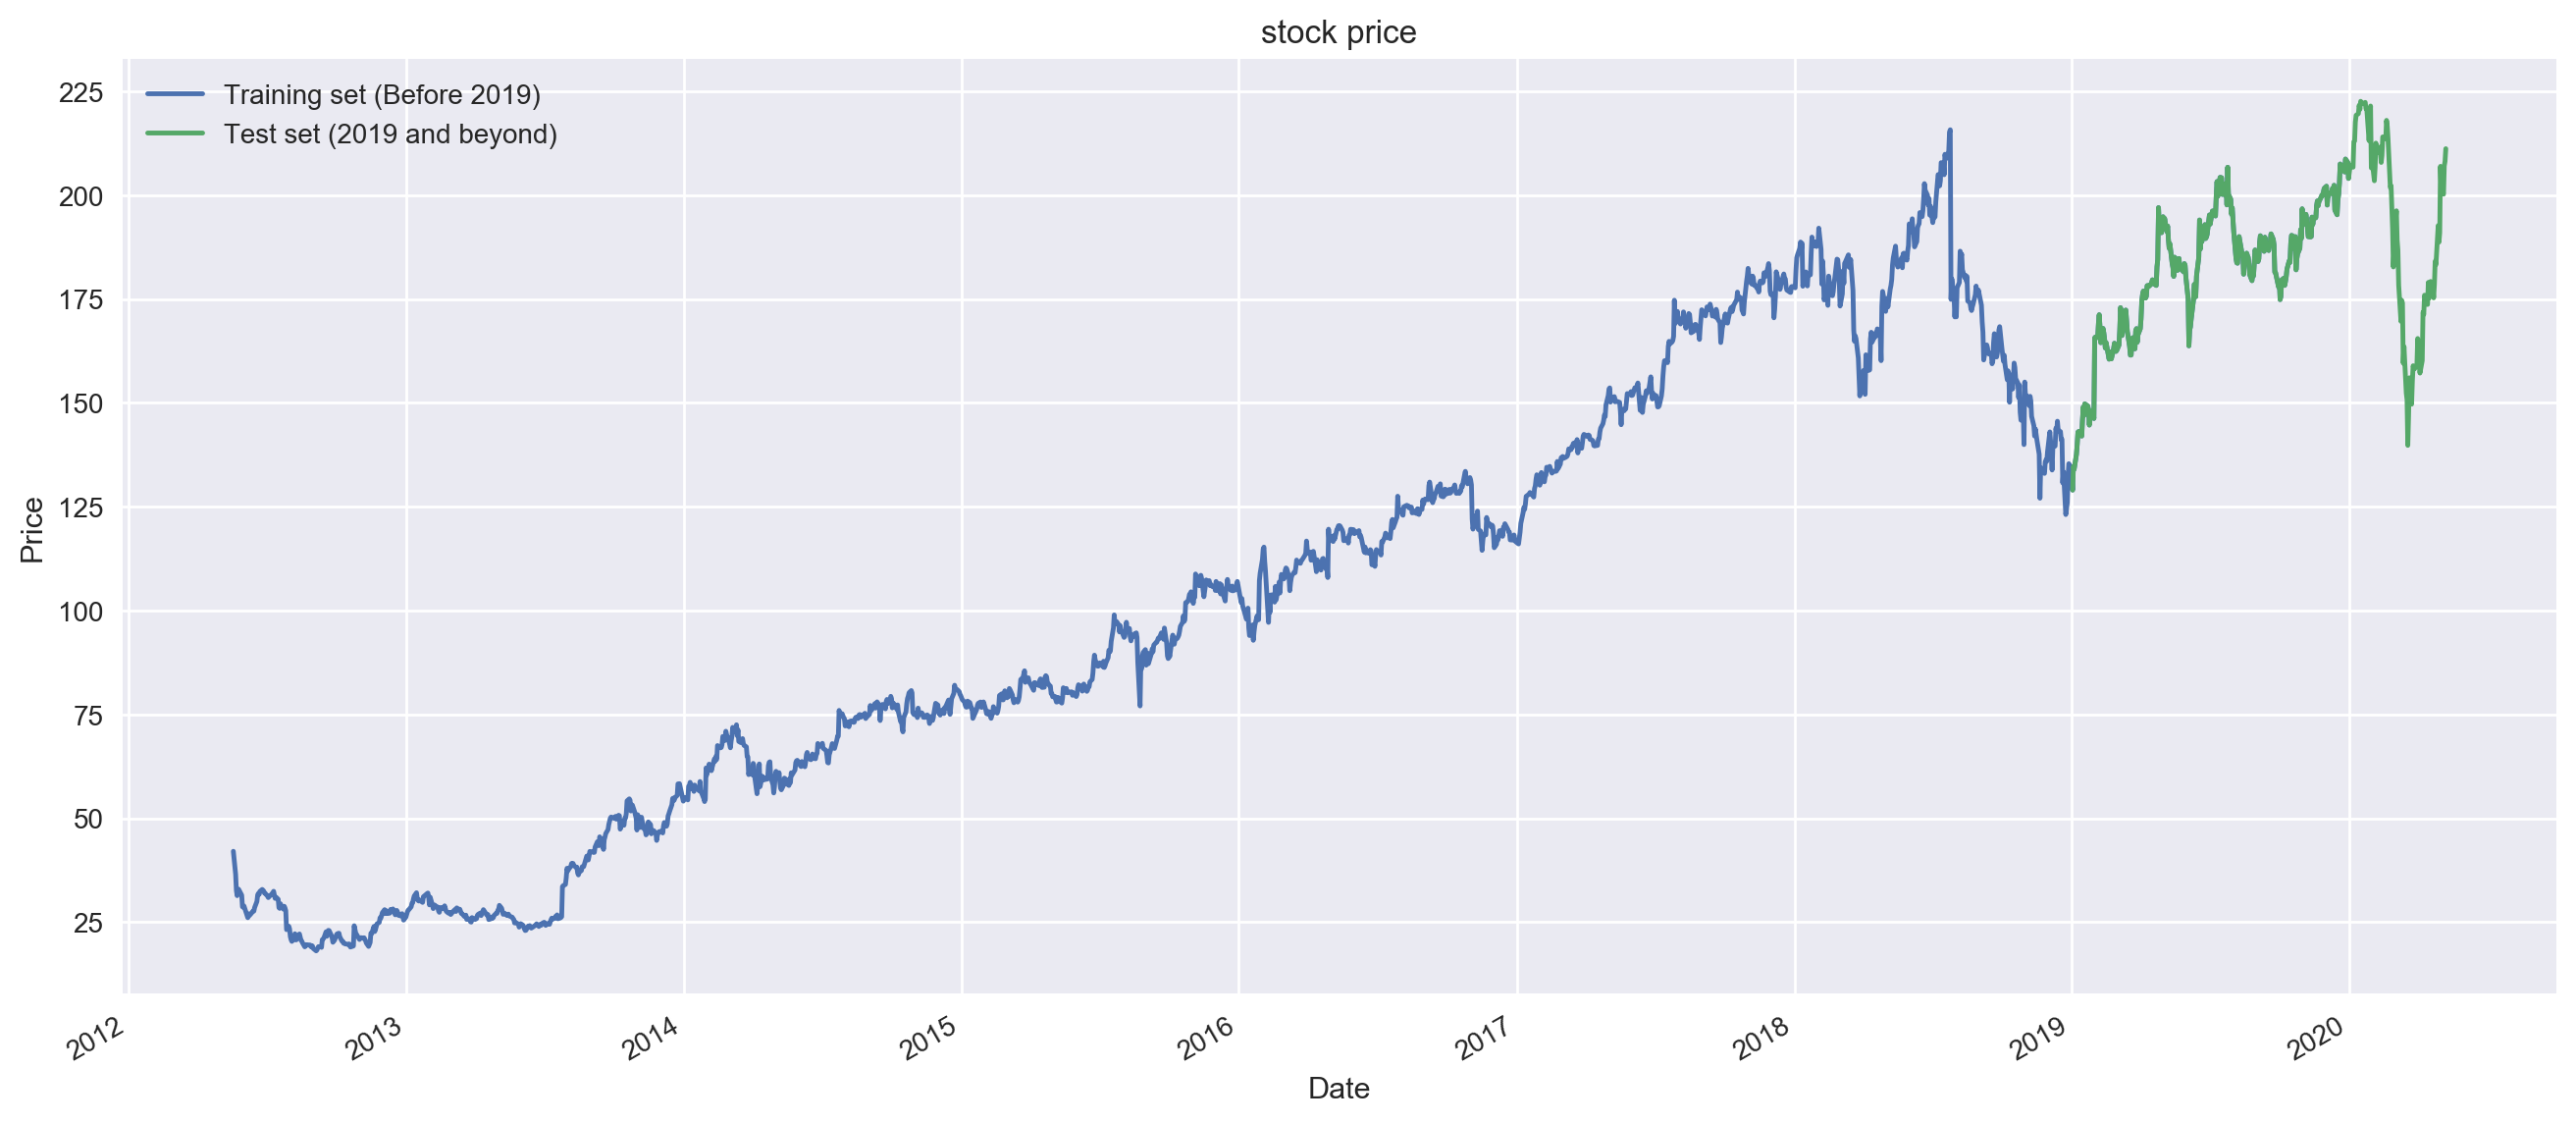

In [8]:
plt.figure(dpi=200,figsize=(16,7))
data["Open"][:'2019'].plot(legend=True)
data["Open"]['2019':].plot(legend=True)
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [9]:
train = data[:"2019"]["Open"].values


scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))

trn_x,trn_y = make_dataset(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [10]:
trn_x = trn_x.reshape(-1,60,1)

### Model Architecture

* LSTM(50)
* LSTM(50)
* LSTM(50)
* Dense(500)
* Dropout(0.2)
* Dense(1)

In [11]:
model = tf.keras.models.Sequential()

model.add(tf.compat.v1.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.LSTM(50))

model.add(tf.keras.layers.Dense(500))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model.compile(optimizer='adam', loss='mse')

In [12]:
model.fit(trn_x, trn_y, epochs=300, callbacks=[early_stop])

Train on 1857 samples
Epoch 1/300
1857/1857 [==============================] - 12s 6ms/sample - loss: 0.0295
Epoch 2/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0012
Epoch 3/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0012
Epoch 4/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0013
Epoch 5/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0011
Epoch 6/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0010
Epoch 7/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0012
Epoch 8/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0011
Epoch 9/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 9.6522e-04
Epoch 10/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 9.6833e-04
Epoch 11/300
1857/1857 [==============================] - 8s 4ms/sample - loss: 0.0027
Epoch 12/300
1857/185

## Validation

* Test our model on whole data including test set(2019 and beyond)

In [22]:
total = data['Open'].values
total_scaled = scaler.transform(total.reshape(-1,1))

total_x,total_y = make_dataset(total_scaled,60)

In [23]:
predicted = model.predict(total_x)
predicted = scaler.inverse_transform(predicted)

In [24]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(data['Open'].iloc[60:])
infered['Open_Predicted'] = predicted

In [25]:
infered.tail()

,Open,Open_Predicted
Date,,
2020-05-01,201.600006,206.097778
2020-05-04,200.199997,202.198074
2020-05-05,207.020004,200.032242
2020-05-06,208.119995,206.168762
2020-05-07,211.160004,207.633759


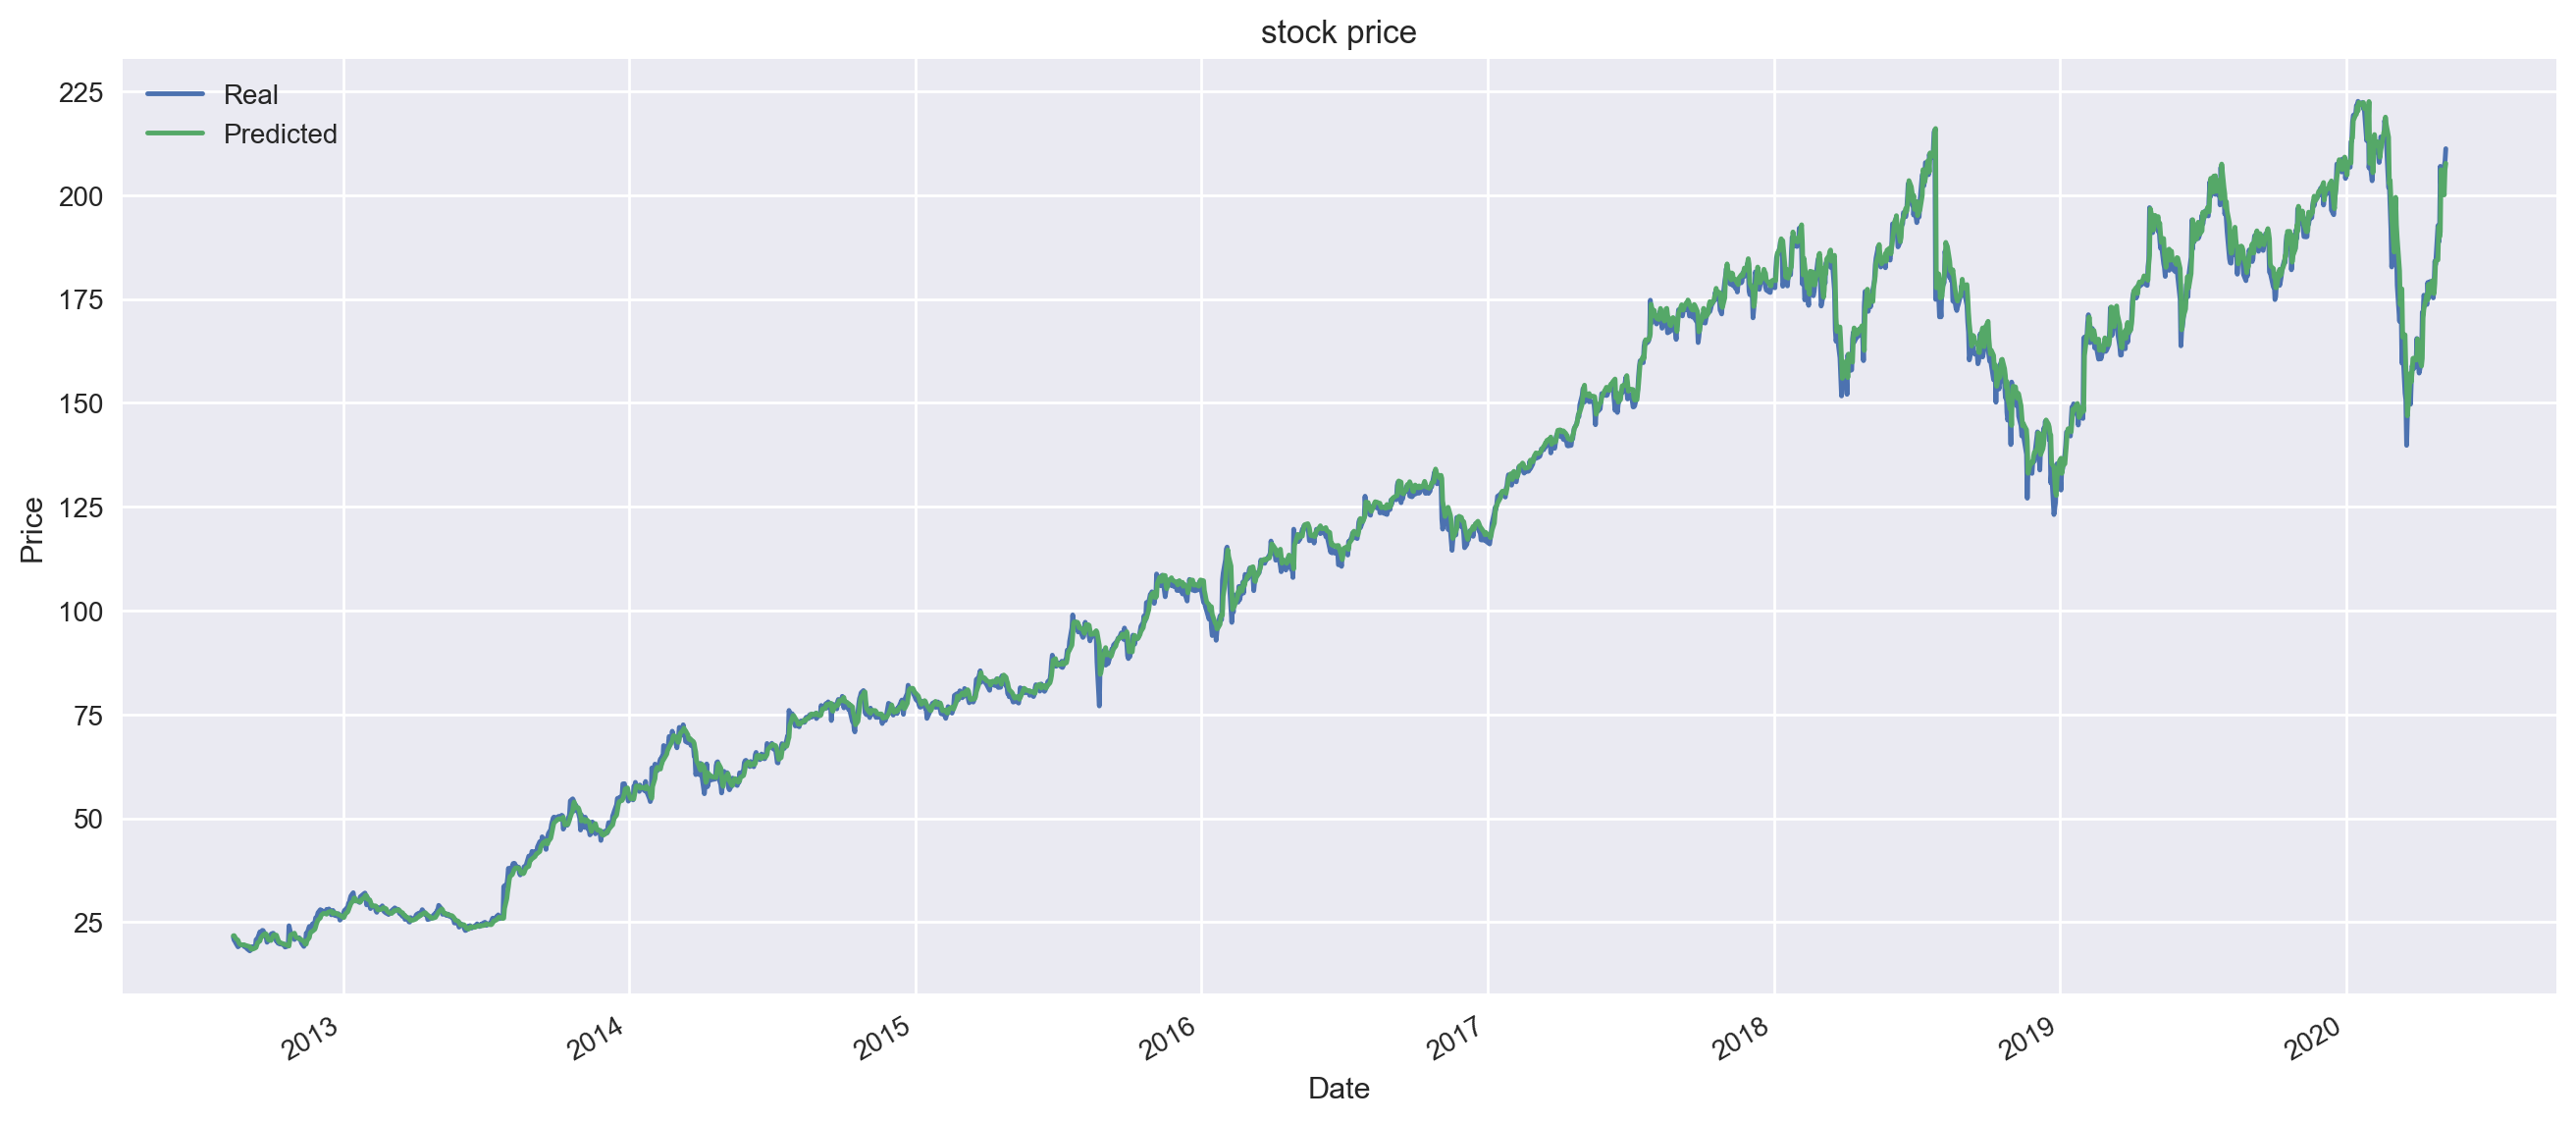

In [26]:
plt.figure(dpi=200,figsize=(16,7))
infered["Open"].plot(legend=True)
infered["Open_Predicted"].plot(legend=True)
plt.legend(['Real','Predicted'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(data['Open'].iloc[60:].values,predicted)
print("RMSE:", np.sqrt(mse))

RMSE: 2.888718136040571


---

## Predicting next N days.

**WARNING**: The last prediction (-1) is based on last *N* predicted data aka. **NOT REAL DATA**. This *might* be useful for trend analysis.

In [28]:
#get last predicted value from dataset.

predicted = model.predict(total_x)
last = scaler.inverse_transform(predicted)[-1]
last = list(last)[-1]

last_p = [last]

print(last_p)

[207.63376]


In [29]:
#Edit Me!
n = 13


for day in range(n):
    print("Remove index 0:", total_scaled[0], "| Add last predicted:", last_p[-1])
    
    #convert to list
    total = list(data['Open'].values)
    
    #remove/exclude 1st (0th index)
    total = total[1:]
    
    #add predictions as data to dataset
    for p in last_p:
        print("Added > ",p)
        total.append(p)
    
    #convert to numpy array
    total = np.array(total)
    
    #Scale data!
    total_scaled = scaler.transform(total.reshape(-1,1))
    
    total_x,total_y = make_dataset(total_scaled,60)

    
    predicted = model.predict(total_x)
    predicted = scaler.inverse_transform(predicted)
    last = list(predicted[-1])[0]
    print("Model Prediction: ", last)

    last_p.append(last)

Remove index 0: [0.12128111] | Add last predicted: 207.63376
Added >  207.63376
Model Prediction:  210.54594
Remove index 0: [0.09335154] | Add last predicted: 210.54594
Added >  207.63376
Added >  210.54594
Model Prediction:  207.20993
Remove index 0: [0.09335154] | Add last predicted: 207.20993
Added >  207.63376
Added >  210.54594
Added >  207.20993
Model Prediction:  210.01416
Remove index 0: [0.09335154] | Add last predicted: 210.01416
Added >  207.63376
Added >  210.54594
Added >  207.20993
Added >  210.01416
Model Prediction:  207.07578
Remove index 0: [0.09335154] | Add last predicted: 207.07578
Added >  207.63376
Added >  210.54594
Added >  207.20993
Added >  210.01416
Added >  207.07578
Model Prediction:  209.95319
Remove index 0: [0.09335154] | Add last predicted: 209.95319
Added >  207.63376
Added >  210.54594
Added >  207.20993
Added >  210.01416
Added >  207.07578
Added >  209.95319
Model Prediction:  207.39682
Remove index 0: [0.09335154] | Add last predicted: 207.39682


---
## Compare Results

In [30]:
data_last_14days["Predicted"] = last_p
data_last_14days[["Open", "Predicted"]]

,Open,Predicted
Date,,
2020-05-08,212.240005,207.633759
2020-05-11,210.889999,210.545944
2020-05-12,213.289993,207.209930
2020-05-13,209.429993,210.014160
2020-05-14,202.559998,207.075775
2020-05-15,205.270004,209.953186
2020-05-18,212.149994,207.396820
2020-05-19,213.270004,210.303635
2020-05-20,223.500000,208.027908
